In [2]:
import nbsetup
import numpy as np
import seaborn as sns
import pandas as pd
import ensemblepy as ep
import scipy as sp
import matplotlib.pyplot as plt
import time

In [3]:
from ensemblepy.densityvar import generate_cache
vs = generate_cache(dimensions=3, power=0.5, timings=True)

1 0.6542849540710449
2 10.60320782661438
3 94.0850739479065


In [4]:
vs

{(10, (-0.5, 1.5), 2000, 0.5, 1): (0.027235057229587082, 0.06288169464353091),
 (10, (-0.5, 1.5), 2000, 0.5, 2): (0.006418550148641414, 0.012252874433871614),
 (10, (-0.5, 1.5), 2000, 0.5, 3): (0.001487461053166451, 0.002499112437525661)}

In [3]:
def disent(dist, b, x, d=1, bins=None):
    if bins is None: bins = [np.linspace(0,1,b+1),]
    pmf = np.histogramdd(dist, bins=bins)[0].flatten()
    ent = sp.stats.entropy(pmf)
    maxe = np.log(len(pmf))
    return {'x': x,
            'bins': b,
            'dimension': d,
            'entropy': ent,
            'ent/maxent': ent/maxe,
            'LDDP': maxe-ent
           }

In [10]:
def compare(title, func, dimensions=range(1, 3+1), percent=np.linspace(0,1,11), binrange=(2,3,5,10)):
    tic = time.time()
    data = []
    discrete = []
    for x in percent:
        for d in dimensions:
            dist = np.array([func(x, d) for _ in range(d)]).T
            data.append({
                'x': x,
                'y': ep.density_variance(dist, power=2, vs=vs),
                'dimension': d,
            })
            for k in binrange:
                bins = np.array([np.linspace(0,1, k+1) for _ in range(d)])
                discrete.append(disent(dist, k, x, d, bins))
            nbsetup.cp(title, 'd =', d, 'x =', x, 'time =', time.time()-tic)
    return pd.DataFrame(data), pd.DataFrame(discrete)

In [5]:
def plot_dv(title, func, data, discrete, save=True):
    dimensions = data['dimension'].unique()
    fig, axes = plt.subplots(1,len(dimensions)+1, figsize=(15,4))
    
    g = sns.lineplot(data=data, x='x', y='y', hue='dimension', ax=axes[0],
        palette=sns.dark_palette("#69d", reverse=True, as_cmap=True)).set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1),
          xlabel='Distribution variable x', title='Density variance', ylabel=None)
    
    for i, d in enumerate(dimensions):
        df = data[data['dimension']==d]
        sns.lineplot(data=discrete[discrete['dimension'] == d], x='x',
            y='ent/maxent', hue='bins', ax=axes[i+1]).set(title='%s Dimension' % d,
                xlim=(-0.1, 1.1), ylim=(-0.1, 1.1), ylabel=None)
        sns.lineplot(x=df['x'], y=df['y'], ax=axes[i+1],
                     color='deepskyblue', linestyle='dashed').set(ylabel=None, xlabel='Distribution variable x')
    if save:
        pass#fig.savefig('%s-dv.eps' % title)

In [6]:
COUNT = 1000
PLOTS = {
    'perfect': lambda p, d: np.concatenate([np.random.uniform(0, 1, int(COUNT*d*p)), np.ones(int(COUNT*d*(1-p)))*0.5]),
    'points': lambda p, d: np.concatenate([np.ones(COUNT//10)*(0.5+p/2),np.ones(COUNT//10)*(0.5-p/2)]),
    'block': lambda p, d: np.random.uniform(0, p, COUNT*d),
    #'flat': lambda p, d: np.ones(COUNT//5)*p,
}

In [12]:
vs

{(10, (-0.5, 1.5), 2000, 0.5, 1): (0.0273061508820408, 0.06288169464353092),
 (10, (-0.5, 1.5), 2000, 0.5, 2): (0.006425467837286778, 0.012252874433871614),
 (10, (-0.5, 1.5), 2000, 0.5, 3): (0.0014845103684344202,
  0.002499112437525661),
 (10, (-0.5, 1.5), 2000, 2, 1): (0.0002946371093883775, 0.022493281683560185),
 (10, (-0.5, 1.5), 2000, 2, 2): (1.240824846973438e-06, 0.0009443906894674336),
 (10, (-0.5, 1.5), 2000, 2, 3): (9.294391869419493e-09,
  4.3580993838041065e-05)}

block d = 3 x = 1.0 time = 26.970598936080933


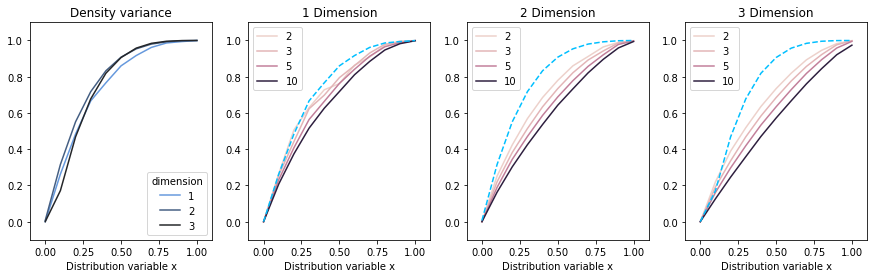

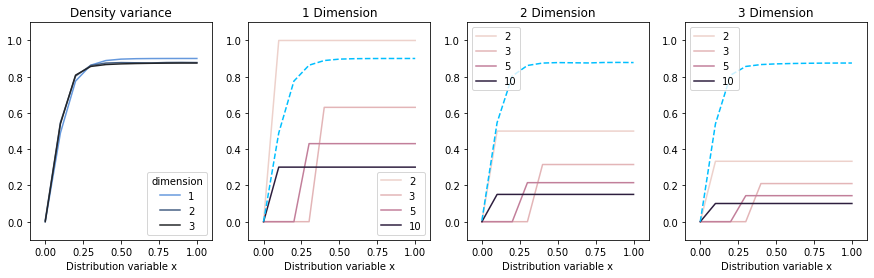

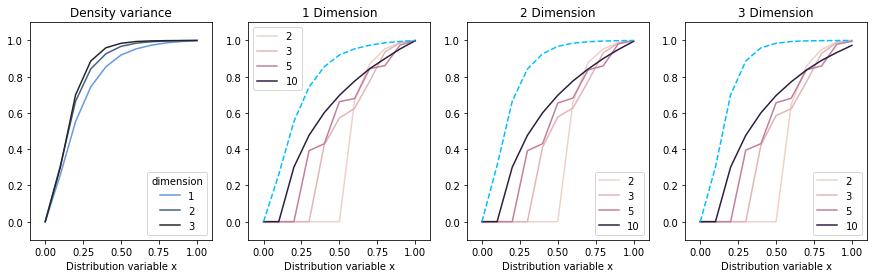

In [11]:
for item in PLOTS.items():
    plot_dv(*item, *compare(*item))

block d = 3 x = 1.0 time = 26.92001700401306


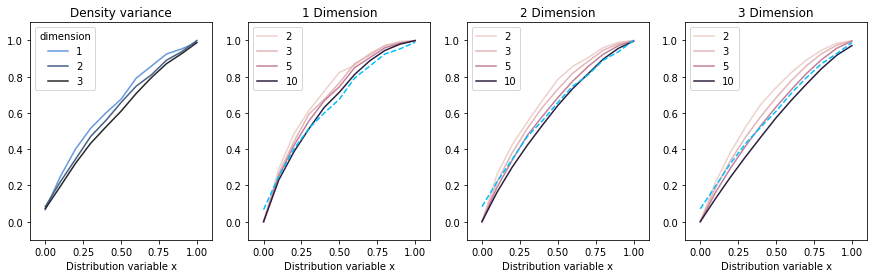

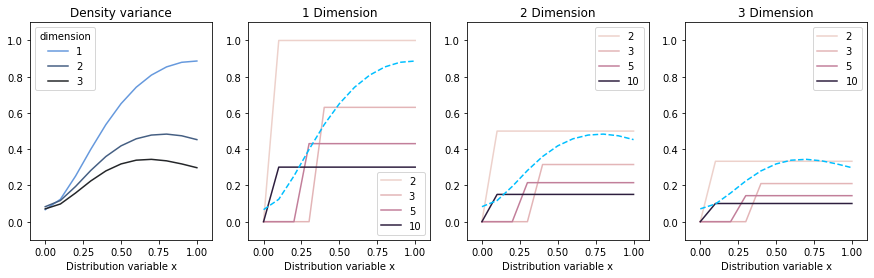

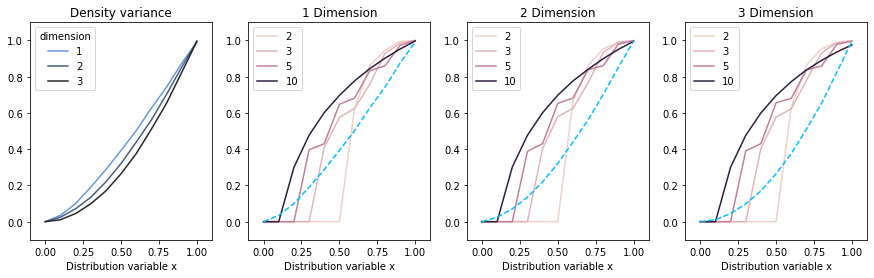

In [8]:
for item in PLOTS.items():
    plot_dv(*item, *compare(*item))

In [8]:
def plot_comparison(title, func, total=3, binrange=range(2,30), save=True):
    fig, axes = plt.subplots(2, total, figsize=(15,8))

    maxd = None
    for i in range(total):
        # hists
        x = i/(total-1)
        dist = func(x, 1)
        sns.histplot(dist, bins=11, binrange=(0,1), ax=axes[0][i], color='lightgrey'
                ).set(title="1D distribution for x=%.1f" % x, ylabel=None)
        dens, steps = ep.densities(dist, steps=100)
        if maxd is None: maxd = dens.max()
        sns.lineplot(x=steps.T[0], y=dens, color='deepskyblue',
                     linestyle='dashed', ax=axes[0][i].twinx()).set(
                        ylabel=None, yticks=[], ylim=(0, maxd*1.1))
        
        # comparisons
        df = pd.DataFrame([disent(dist, b, x) for b in binrange])
        sns.lineplot(data=df.melt(id_vars=('x','bins','dimension')),
                     x='bins', y='value', hue='variable', ax=axes[1][i], palette=sns.color_palette("Set2", 3))
        dv = ep.density_variance(dist)
        sns.lineplot(x=[binrange[0], binrange[-1]], y=[dv,dv],
                     ax=axes[1][i], color='deepskyblue', linestyle='dashed',
                     label='dens.var.').set(ylabel=None, xlabel='Number of bins')
        
    if save:
        fig.savefig('%s-compare.eps' % title)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


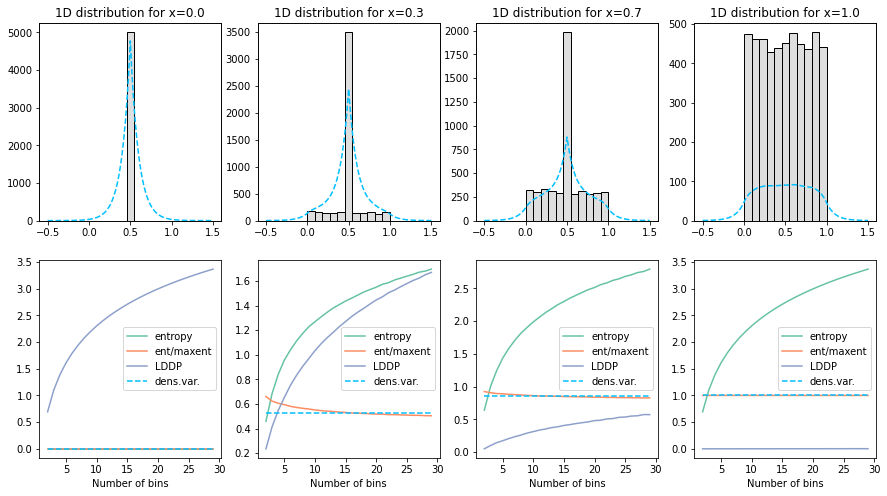

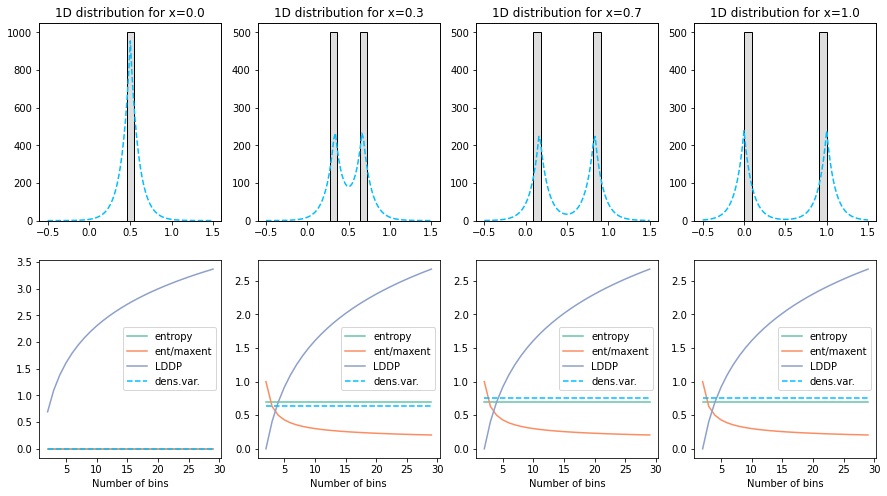

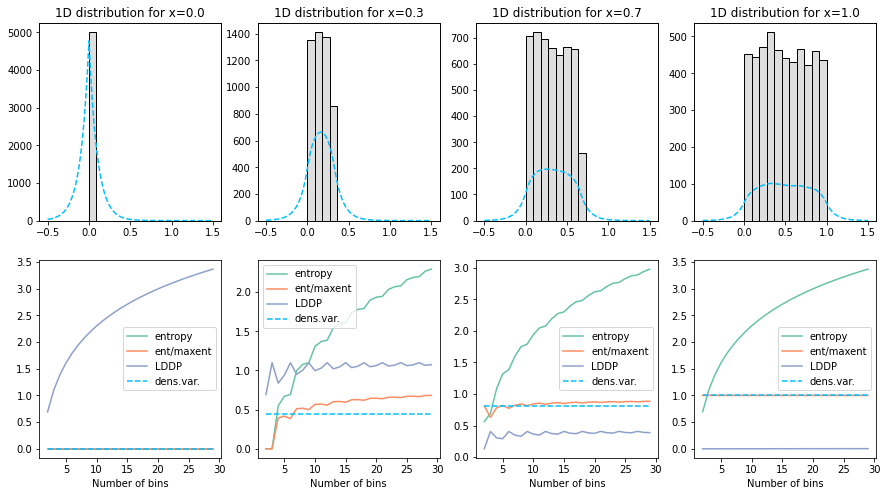

In [9]:
for item in PLOTS.items():
    plot_comparison(*item, 4)